# Chapter 11: Training Deep Neural Networks

In [1]:
# Libraries

import sklearn
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os

np.random.seed(42)

# Plotting
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## 1. Activations

### 1.1 Vanishing and Exploding Gradients

In [2]:
def logit(z):
    return 1 / (1 + np.exp(-z))

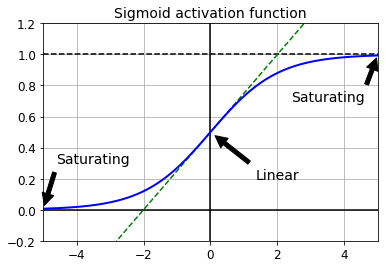

In [3]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

plt.show()

### 1.2 Xavier-He Initialization

- _Idea_ : want variance of outputs to be approximately equal to variance of inputs (before/after flow in backprop)

- The following holds for the sigmoid initialization:

$$\mathrm{Glorot \; normal \; init} \sim \mathcal{N} \bigg(0, \, \frac{2}{a^{[\ell]} + a^{[\ell - 1]}} \bigg)$$
$$\mathrm{Glorot \; uniform \; init} \sim U \bigg[-\sqrt{\frac{6}{a^{[\ell]} + a^{[\ell - 1]}}} , \, \sqrt{\frac{6}{a^{[\ell]} + a^{[\ell - 1]}}} \bigg]$$

For $a_{\mathrm{avg}} = \frac{a^{[\ell]} + a^{[\ell - 1]}}{2}$, have:
   - __Glorot__ : for tanh, logistic, softmax -- $\sigma^2 = \frac{1}{a_{\mathrm{avg}}}$
   - __He__ : for ReLU -- $\sigma^2 = \frac{2}{a^{[\ell - 1]}}$

In [4]:
# List of initializations

[name for name in dir(keras.initializers) if not name.startswith("_")]

['Constant',
 'GlorotNormal',
 'GlorotUniform',
 'HeNormal',
 'HeUniform',
 'Identity',
 'Initializer',
 'LecunNormal',
 'LecunUniform',
 'Ones',
 'Orthogonal',
 'RandomNormal',
 'RandomUniform',
 'TruncatedNormal',
 'VarianceScaling',
 'Zeros',
 'constant',
 'deserialize',
 'get',
 'glorot_normal',
 'glorot_uniform',
 'he_normal',
 'he_uniform',
 'identity',
 'lecun_normal',
 'lecun_uniform',
 'ones',
 'orthogonal',
 'random_normal',
 'random_uniform',
 'serialize',
 'truncated_normal',
 'variance_scaling',
 'zeros']

In [6]:
# By default, Karas uses Glorot uniform
# Can change to He:

keras.layers.Dense(10, activation = "relu", kernel_initializer = "he_normal")

In [7]:
# Can manually adjust He based on average rather than input dimension:

init = keras.initializers.VarianceScaling(scale = 2.0, mode = "fan_avg", distribution = "uniform")
keras.layers.Dense(10, activation = "relu", kernel_initializer = init)

### 1.3 Nonsaturating Activation Functions

#### 1.3.1 Leaky ReLU

- Problem with ReLU: activations "die" because of 0 derivative on the left
- Neuron dies when weighted sum of inputs negative for all instances in training set -- will be unaltered by GD!
- Attempt to solve by leaky ReLU: $\mathrm{LeakyReLU}_{\alpha}(z) = \max(\alpha z, \, z)$

__Notes__ :
   - Typically, large leak $\alpha = 0.2$ might do better than small $\alpha = 0.01$
   - _Randomized leaky ReLU_ : RRELU -- choose $\alpha$ at random during trainign, and fix to average value during test
   - _Parameterized leaky ReLU_ : PReLU -- learn $\alpha$ during training (works well on large datasets)